In [2]:
import torch
import torchvision

In [4]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [6]:
examples = enumerate(test_loader)

In [6]:
batch_idx, (example_data, example_targets) = next(examples)

In [46]:
test_loader

In [7]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [43]:
(torch.randint(0,100,(1,1000))+example_targets)

tensor([[ 84,  15,  68,   9, 102,  43,  75,  85,  29,  99,  52,  99,  41,   6,
          28,  89,  80, 101,  80, 100,  23,  19,  64,  55,  26, 103,  45,  27,
          62,  67,  42,  51,  97,  47,  76, 101,  39,  89,  63,  17,  77,  69,
          77,  40,  76,  48,  18,  60,  64,  17, 104,  14,  26,  50,  77,  91,
          13,  88,  69,  11,  89,   7, 103,  46,  10,  23,  55,  50,  37, 106,
          17,  96,  25,  45,  76,  30,  73,  87,  14,  70,  11,  92,  58,  11,
          87,   0,  74,  70,  54, 101,  38,  86,  30,  60,  71,  58,  43,  88,
          72,  53, 105,  25,  46,  75,  48,   8,  43,  34,  63, 101,  54,  92,
          32,  39,  63,  99,  99,  64,  38,  47,  42,  11,  52,  97,  44,  35,
          64,  21,  13,  87,  79,  16,  78,   9,  61,  69,  44,  78,  97,  77,
          20, 103,  98,   8,  45,  20,  34,   3,  97,  22,  16,  51,  20,  77,
          48,   9,  16,  14,  72,  21,  22,  71,  95,  41,  15,  28, 102,  97,
          90,  78,  51,  46,  81,  85,  19,   6,  54

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)  ## flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [18]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [19]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [20]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

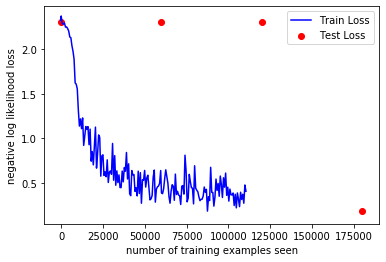

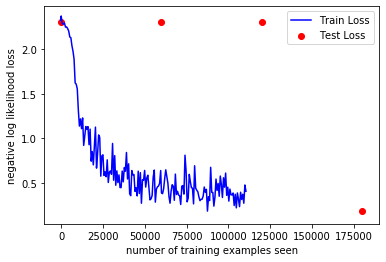

In [21]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [22]:
with torch.no_grad():
  output = network(example_data)

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
